In [1]:
# standard imports
import os
import json
import sys; sys.path.append(os.path.dirname(os.path.realpath(".")))

# external imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# internal imports
from utils.results.rank_analysis import mean_rank, wilcoxon_holm
from utils.results.plots import graph_ranks
from utils.results.utils import (
    from_result_dict_to_long_format, 
    from_result_dict_to_param_long_format,
    from_long_format_to_matrix
)

In [29]:
%matplotlib inline

# Import data

## results dict

In [2]:
ls ../results

benchmark_15_09_2020.zip  predictions_2020_09_15.csv  results_2020_08_14.csv
datasets_summary.csv      predictions_2020_09_17.csv  results_2020_08_25.csv
param_2020_08_25.csv      result_5_8_2020/            results_2020_09_15.csv
param_2020_09_15.csv      results_17_09_2020/         results_2020_09_17.csv
param_2020_09_17.csv      results_2020_08_13.csv      results_25_08_2020/


In [3]:
result_dict = {}
for e in os.scandir("../results/results_17_09_2020"):
#for e in os.scandir("."):
    #if ("_dataset_result_16_09_2020.json" in e.name) or ("_dataset_result_17_09_2020.json" in e.name):
    name = e.name[:-30]
    with open(e) as fp:
        result_dict[name] = json.loads(fp.read())

## predictions

In [4]:
def from_result_dict_to_prediction_long_format(result_dict):
    # initialisation
    columns = ["evaluator", "dataset", "metric", "fold_idx", "y_true", "y_pred"]
    result_long = []
    for dataset in result_dict:
        for evaluator in result_dict[dataset]:
            for metric in result_dict[dataset][evaluator]["test_predictions"]:
                predictions = result_dict[dataset][evaluator]["test_predictions"][metric]
                for fold_idx, pred in enumerate(predictions):
                    for y_true, y_pred in zip(pred["y_true"], pred["y_pred"]):
                        result_long.append(
                            [
                                evaluator,
                                dataset,
                                metric,
                                fold_idx,
                                y_true,
                                y_pred
                            ]
                        )
    return pd.DataFrame(data=result_long, columns=columns)

In [5]:
pred_long_df = from_result_dict_to_prediction_long_format(result_dict)
pred_long_df["dataset"] = pred_long_df["dataset"].str[:-1]

print(pred_long_df.shape)
pred_long_df.head()

(1058508, 6)


,evaluator,dataset,metric,fold_idx,y_true,y_pred
0,sklearn_decisiontree,residential_25,r2,0,111.80,117.855833
1,sklearn_decisiontree,residential_25,r2,0,202.60,117.855833
2,sklearn_decisiontree,residential_25,r2,0,175.65,179.546154
3,sklearn_decisiontree,residential_25,r2,0,183.56,179.546154
4,sklearn_decisiontree,residential_25,r2,0,122.11,179.546154


In [6]:
for col in ["evaluator", "dataset"]:
    print(pred_long_df[col].unique())

['sklearn_decisiontree' 'sklearn_randomforest' 'sklearn_elasticnet'
 'craft_decisiontree' 'h2o_randomforest' 'lightgbm_gbdt']
['residential_25' 'residential_19' 'pays_de_la_loire' 'paca'
 'centre_val_de_loire' 'residential_9' 'residential_23' 'bretagne'
 'residential_20' 'residential_13' 'residential_14' 'hauts_de_france'
 'french_ministry_aff_etrangeres' 'grand_est' 'auvergne_rhone_alpes'
 'residential_10' 'ile_de_france' 'residential_24' 'residential_2'
 'residential_7' 'bourgogne_franche_comte' 'residential_6' 'residential_4'
 'residential_12' 'occitanie' 'residential_11' 'synth1_long'
 'residential_3' 'normandie' 'uci_individual_household' 'residential_18'
 'synth1_short' 'nouvelle_aquitaine' 'residential_8' 'residential_5'
 'residential_1']


In [7]:
pred_long_df.to_csv("../results/predictions_2020_09_17.csv", index=False)

## params

In [8]:
param_long_df = from_result_dict_to_param_long_format(result_dict)
param_long_df["dataset"] = param_long_df["dataset"].str[:-1]
print(param_long_df.shape)
param_long_df.head()

(3384, 5)


,evaluator,dataset,metric,param_name,param_value
0,sklearn_decisiontree,residential_25,r2,max_depth,2
1,sklearn_decisiontree,residential_25,r2,max_features,NaN
2,sklearn_decisiontree,residential_25,r2,max_leaf_nodes,NaN
3,sklearn_decisiontree,residential_25,r2,min_samples_leaf,20
4,sklearn_decisiontree,residential_25,r2,min_samples_split,2


In [9]:
param_long_df.replace({None: np.nan}).groupby(["evaluator", "param_name"])["param_value"].nunique()

evaluator             param_name                      
craft_decisiontree    min_samples_per_leaf                6
                      tree_max_depth                      4
h2o_randomforest      balance_classes                     1
                      categorical_encoding                1
                      col_sample_rate_change_per_level    1
                      col_sample_rate_per_tree            1
                      histogram_type                      1
                      ignore_const_cols                   1
                      max_depth                           1
                      min_rows                            1
                      min_split_improvement               1
                      mtries                              5
                      nbins                               1
                      nbins_cats                          1
                      nbins_top_level                     1
                      ntrees                 

In [10]:
param_long_df[
    (param_long_df["evaluator"] == "craft_decisiontree")
    & (param_long_df["dataset"].isin(["residential_8", "residential_12", "synth1_short"]))
].infer_objects().groupby("param_name")["param_value"].describe()

,count,mean,std,min,25%,50%,75%,max
param_name,,,,,,,,
min_samples_per_leaf,6.0,3.333333,2.065591,2.0,2.0,2.0,5.0,6.0
tree_max_depth,6.0,5.000000,2.449490,2.0,4.0,4.0,7.0,8.0


In [19]:
param_long_df[
    param_long_df["evaluator"].str.contains("decisiontree")
    & (param_long_df["dataset"] == "residential_12")
    & (param_long_df["metric"] == "r2")
]

,evaluator,dataset,metric,param_name,param_value
2162,sklearn_decisiontree,residential_12,r2,max_depth,8
2163,sklearn_decisiontree,residential_12,r2,max_features,NaN
2164,sklearn_decisiontree,residential_12,r2,max_leaf_nodes,NaN
2165,sklearn_decisiontree,residential_12,r2,min_samples_leaf,50
2166,sklearn_decisiontree,residential_12,r2,min_samples_split,2
2194,craft_decisiontree,residential_12,r2,min_samples_per_leaf,2
2195,craft_decisiontree,residential_12,r2,tree_max_depth,8


In [12]:
param_long_df.to_csv("../results/param_2020_09_17.csv", index=False)

## results

In [13]:
result_long_df = from_result_dict_to_long_format(result_dict)
result_long_df["dataset"] = result_long_df["dataset"].str[:-1]
display(result_long_df.head())

,evaluator,dataset,metric,is_test,fold_idx,value
0,sklearn_decisiontree,residential_25,r2,False,0.0,0.005218
1,sklearn_decisiontree,residential_25,r2,False,1.0,0.208602
2,sklearn_decisiontree,residential_25,r2,False,2.0,0.048682
3,sklearn_decisiontree,residential_25,mae,False,0.0,39.125192
4,sklearn_decisiontree,residential_25,mae,False,1.0,31.681511


In [14]:
result_long_df["dataset"].nunique()

36

In [15]:
result_long_df["evaluator"].nunique()

6

In [16]:
result_long_df["metric"].unique()

array(['r2', 'mae', 'mean_fit_time', 'gridsearch_time'], dtype=object)

In [17]:
result_long_df.groupby(["evaluator", "dataset", "is_test", "fold_idx", "metric"]).nunique().max()

value    1
dtype: int64

In [18]:
result_long_df.shape

(3216, 6)

In [19]:
result_long_df.to_csv("../results/results_2020_09_17.csv", index=False)

In [20]:
mean_result_long_df = result_long_df.fillna("nan").groupby(["dataset", "evaluator", "metric", "is_test"])["value"].mean().reset_index().replace({"nan": np.nan})
mean_result_long_df.head()

,dataset,evaluator,metric,is_test,value
0,auvergne_rhone_alpes,craft_decisiontree,gridsearch_time,NaN,1149.168220
1,auvergne_rhone_alpes,craft_decisiontree,mae,False,672.824951
2,auvergne_rhone_alpes,craft_decisiontree,mae,True,611.352475
3,auvergne_rhone_alpes,craft_decisiontree,mean_fit_time,NaN,1.354692
4,auvergne_rhone_alpes,craft_decisiontree,r2,False,0.900689


In [21]:
mean_result_long_df[
    (mean_result_long_df["evaluator"].str.contains("decisiontree")
    & (mean_result_long_df["dataset"] == "residential_12"))
    & (mean_result_long_df["metric"] == "r2")
]

,dataset,evaluator,metric,is_test,value
580,residential_12,craft_decisiontree,r2,False,0.097704
581,residential_12,craft_decisiontree,r2,True,-0.104754
598,residential_12,sklearn_decisiontree,r2,False,0.068692
599,residential_12,sklearn_decisiontree,r2,True,0.207062


## datasets info

In [22]:
info_df = pd.read_csv("../results/datasets_summary.csv")
print(info_df.shape)
info_df.head()

(36, 13)


,dataset,n_samples,n_predictors,n_continuous_predictors,n_enum_predictors,n_time_of_day_predictors,n_day_of_week_predictors,n_day_of_month_predictors,n_month_of_year_predictors,time_period (month),freq (hour),retrain_freq (day),prediction_horizon (day)
0,synth1_long,7000,5,2,2,0,1,0,0,229.0,24.0,175.0,1.0
1,synth1_short,140,5,2,2,0,1,0,0,4.0,24.0,7.0,1.0
2,residential_1,173,10,7,1,0,0,1,1,39.0,168.0,182.0,7.0
3,residential_2,12564,12,7,1,1,1,1,1,41.0,3.0,91.0,1.0
4,residential_3,1076,11,7,1,0,1,1,1,35.0,24.0,91.0,7.0


In [23]:
info_df.set_index("dataset").loc[["residential_8", "residential_12", "synth1_short"], :]

,n_samples,n_predictors,n_continuous_predictors,n_enum_predictors,n_time_of_day_predictors,n_day_of_week_predictors,n_day_of_month_predictors,n_month_of_year_predictors,time_period (month),freq (hour),retrain_freq (day),prediction_horizon (day)
dataset,,,,,,,,,,,,
residential_8,155,10,7,1,0,0,1,1,35.0,168.0,182.0,7.0
residential_12,1083,11,7,1,0,1,1,1,35.0,24.0,91.0,1.0
synth1_short,140,5,2,2,0,1,0,0,4.0,24.0,7.0,1.0


# Mean rank

In [24]:
def mean_ranks(mean_result_long_df):
    mean_ranks = {}
    for metric_name in mean_result_long_df["metric"].unique():
        if "time" in metric_name:
            continue
        greater_is_better = True if metric_name == "r2" else False
        result_matrix = from_long_format_to_matrix(mean_result_long_df, metric_name, True)
        rank_table = result_matrix.rank(axis=0, ascending=not greater_is_better)
        mean_ranks[metric_name] = rank_table.mean(axis=1)
        #mean_ranks[f"{metric_name}_std"] = rank_table.std(axis=1)
    mean_ranks = pd.DataFrame(mean_ranks)
    mean_ranks["mean"] = mean_ranks.filter(regex=".*(?!<_std)$").mean(axis=1)
    return mean_ranks.sort_values(by="mean")

mean_rank_df = mean_ranks(mean_result_long_df)
mean_rank_df.round(2)

,mae,r2,mean
evaluator,,,
lightgbm_gbdt,2.39,2.11,2.25
sklearn_randomforest,2.75,2.42,2.58
h2o_randomforest,2.50,3.11,2.81
sklearn_elasticnet,3.92,3.72,3.82
sklearn_decisiontree,4.47,4.67,4.57
craft_decisiontree,4.97,4.97,4.97


# Critical difference Diagrams

In [18]:
%matplotlib inline

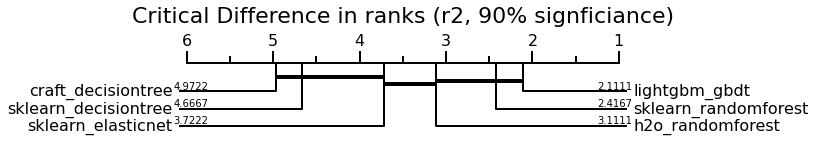

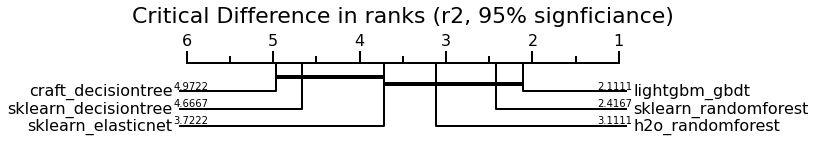

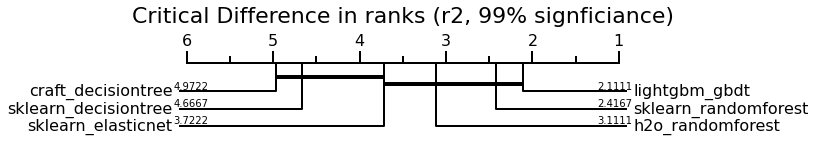

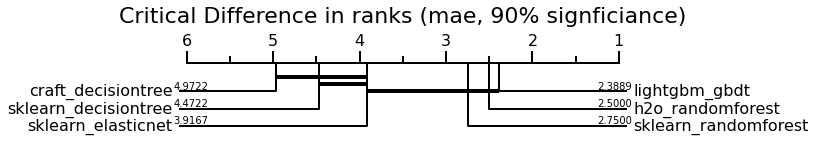

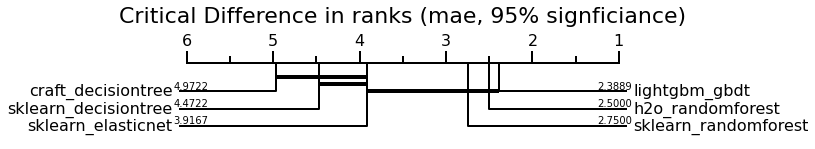

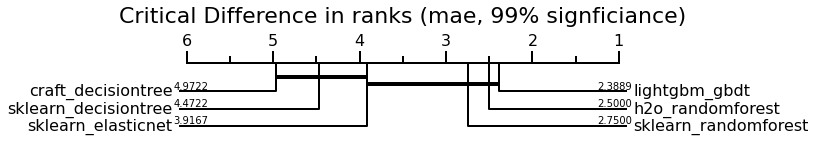

In [30]:
def draw_cd_diagrams(result_long_df, metric_name, greater_is_better, alpha):
    wilcoxon_holm_p_values = wilcoxon_holm(result_long_df, metric_name, greater_is_better, alpha=alpha)
    mean_rank_df = mean_rank(result_long_df, metric_name, greater_is_better)
    
    ax = graph_ranks(
        mean_rank_df,
        wilcoxon_holm_p_values,
        reverse=True,
        width=9,
        textspace=1.5,
        labels=True,
        title="Critical Difference in ranks ({}, {:.0%} signficiance)".format(metric_name, 1-alpha)
    )
    plt.show()

for metric_name, greater_is_better in [("r2", True), ("mae", False)]:
    for alpha in [0.1, 0.05, 0.01]:
        draw_cd_diagrams(mean_result_long_df, metric_name, greater_is_better, alpha)
    print("\n"*3)

In [27]:
draw_cd_diagrams(mean_result_long_df, "r2", True, alpha=0.2)
wilcoxon_holm_p_values = wilcoxon_holm(mean_result_long_df, "r2", True, alpha=0.2)
[(r.name_1, r.name_2, r.p_value, r.is_significant)for r in wilcoxon_holm_p_values]

/home/silvestre/.cache/pypoetry/virtualenvs/benchmarks-v2-Dq-G9kr1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


[('craft_decisiontree', 'lightgbm_gbdt', 3.8848415248747564e-07, True),
 ('lightgbm_gbdt', 'sklearn_decisiontree', 1.93301381077569e-06, True),
 ('craft_decisiontree', 'sklearn_randomforest', 2.257583667112355e-06, True),
 ('sklearn_decisiontree', 'sklearn_randomforest', 4.48611464239504e-06, True),
 ('h2o_randomforest', 'sklearn_decisiontree', 2.9277703999090283e-05, True),
 ('craft_decisiontree', 'h2o_randomforest', 3.136775520963842e-05, True),
 ('lightgbm_gbdt', 'sklearn_elasticnet', 0.005166223468725871, True),
 ('sklearn_elasticnet', 'sklearn_randomforest', 0.01092423368457405, True),
 ('h2o_randomforest', 'lightgbm_gbdt', 0.02674695290138831, False),
 ('sklearn_decisiontree', 'sklearn_elasticnet', 0.0366621565369585, False),
 ('h2o_randomforest', 'sklearn_randomforest', 0.04433035893382051, False),
 ('craft_decisiontree', 'sklearn_elasticnet', 0.05140164804162514, False),
 ('h2o_randomforest', 'sklearn_elasticnet', 0.089745430963276, False),
 ('craft_decisiontree', 'sklearn_deci

In [21]:
mean = mean_result_long_df[
    (mean_result_long_df["metric"] == "r2")
    & (mean_result_long_df["is_test"])
].groupby("dataset")["value"].describe().drop(columns=["count", "std"])

In [22]:
craft = mean_result_long_df[
    (mean_result_long_df["evaluator"] == "craft_decisiontree")
    & (mean_result_long_df["metric"] == "r2")
    & (mean_result_long_df["is_test"])
].set_index("dataset")["value"]
skdt = mean_result_long_df[
    (mean_result_long_df["evaluator"] == "sklearn_decisiontree")
    & (mean_result_long_df["metric"] == "r2")
    & (mean_result_long_df["is_test"])
].set_index("dataset")["value"]
ecart = (craft - skdt)
ecart.describe()

count    36.000000
mean     -0.003833
std       0.178810
min      -0.303309
25%      -0.031810
50%      -0.009398
75%       0.012101
max       0.783901
Name: value, dtype: float64

In [23]:
mean.assign(ecart=ecart).sort_values(by="ecart")

,mean,min,25%,50%,75%,max,ecart
dataset,,,,,,,
residential_12,0.152107,-0.100685,0.151802,0.193685,0.211681,0.270437,-3.033093e-01
residential_8,-0.074983,-0.457056,-0.140725,-0.030726,0.052652,0.165555,-2.961444e-01
synth1_short,-0.082819,-0.681092,-0.297336,0.099825,0.168036,0.223480,-2.652682e-01
residential_10,0.057800,-0.116892,0.052192,0.077674,0.119055,0.131795,-1.635445e-01
residential_4,0.411932,0.261372,0.406424,0.433396,0.453686,0.485545,-1.408540e-01
residential_5,0.095392,-0.110407,0.006419,0.071603,0.154647,0.372536,-1.190274e-01
residential_13,-0.014707,-0.255186,-0.234993,0.002211,0.200629,0.209814,-7.785091e-02
residential_7,0.008073,-0.070173,-0.005885,0.017422,0.038802,0.051491,-5.781691e-02
residential_24,-0.002320,-0.077371,-0.033513,0.010393,0.034565,0.048190,-3.248522e-02


In [24]:
craft = mean_result_long_df[
    (mean_result_long_df["evaluator"] == "craft_decisiontree")
    & (mean_result_long_df["metric"] == "r2")
    & (mean_result_long_df["is_test"])
].set_index("dataset")["value"]
mean_wo_craft = mean_result_long_df[
    (mean_result_long_df["evaluator"] != "craft_decisiontree")
    & (mean_result_long_df["metric"] == "r2")
    & (mean_result_long_df["is_test"])
].groupby("dataset")["value"].min()
ecart = (craft - mean_wo_craft)
ecart.describe()

count    36.000000
mean      0.026915
std       0.180726
min      -0.296144
25%      -0.019258
50%       0.005003
75%       0.060617
max       0.783901
Name: value, dtype: float64

In [25]:
mean.assign(ecart=ecart).sort_values(by="ecart")

,mean,min,25%,50%,75%,max,ecart
dataset,,,,,,,
residential_8,-0.074983,-0.457056,-0.140725,-0.030726,0.052652,0.165555,-2.961444e-01
synth1_short,-0.082819,-0.681092,-0.297336,0.099825,0.168036,0.223480,-2.652682e-01
residential_12,0.152107,-0.100685,0.151802,0.193685,0.211681,0.270437,-2.415056e-01
residential_10,0.057800,-0.116892,0.052192,0.077674,0.119055,0.131795,-1.635445e-01
residential_4,0.411932,0.261372,0.406424,0.433396,0.453686,0.485545,-1.408540e-01
residential_7,0.008073,-0.070173,-0.005885,0.017422,0.038802,0.051491,-5.781691e-02
residential_24,-0.002320,-0.077371,-0.033513,0.010393,0.034565,0.048190,-3.248522e-02
paca,0.952081,0.925349,0.952070,0.955262,0.959068,0.965268,-2.622883e-02
synth1_long,0.540636,0.510203,0.532930,0.542441,0.547063,0.570365,-1.977360e-02


### *Remarks*
- lightgbm is (very) significantly better than others when it comes to r2. Note that by default the loss considered by the gradient boosting is an L2 norm. Maybe it will be better for the mae if we use the setting "objective: regression_L1" (see the [doc](https://lightgbm.readthedocs.io/en/latest/Parameters.html))
- the 2 random forests come second and are not significantly different.
- the simple decision trees are not significantly different (r2-wise).
- elasticnet is the worst by far. Maybe the feature engineering is not suitable for this algo, or the grid wasn't good.

# Time

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


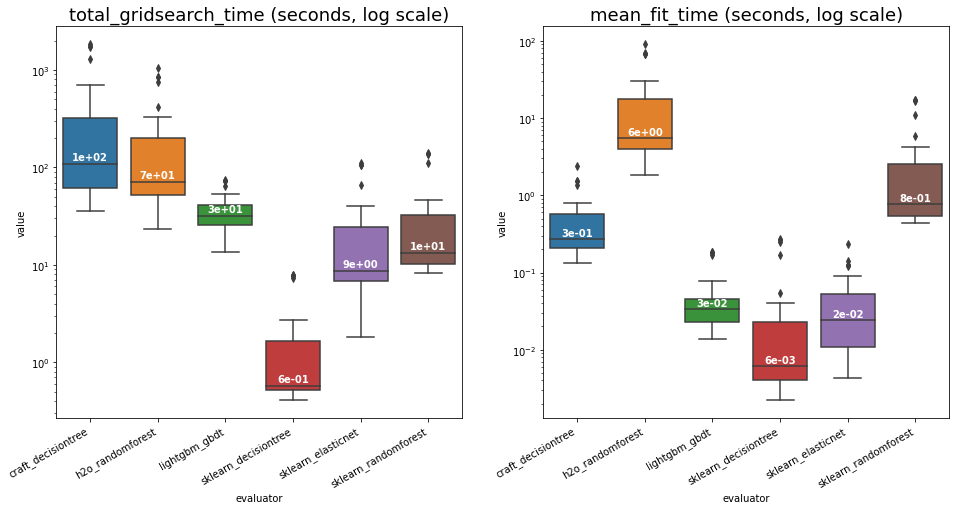

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for ax_idx, metric_name in enumerate(["gridsearch_time", "mean_fit_time"]):
    df = mean_result_long_df[mean_result_long_df["metric"] == metric_name]
    ax = sns.boxplot(
        data=df, 
        x="evaluator",
        y="value",
        ax=axes[ax_idx]
    )
    
    medians = df.groupby(['evaluator'])['value'].median()
    vertical_offset = df['value'].median() * 0.05 # offset from median for display

    for xtick, xticklabel in zip(ax.get_xticks(), ax.get_xmajorticklabels()):
        ax.text(
            xtick, 
            medians[xticklabel.get_text()] * 1.1,
            "{:.0e}".format(medians[xticklabel.get_text()]), 
            horizontalalignment='center',color='w',weight='semibold')
    axes[ax_idx].set_title(f"{metric_name} (seconds, log scale)", fontsize=18)
    axes[ax_idx].set_yscale('log')
fig.autofmt_xdate()
plt.show()

### *Remarks*
- lightgbm is **really fast** when it comes to `fit_time`.
- with equal grid, craft is very slow compared to sklearn (about 50 times more).

# Raw metrics

## *per evaluator*

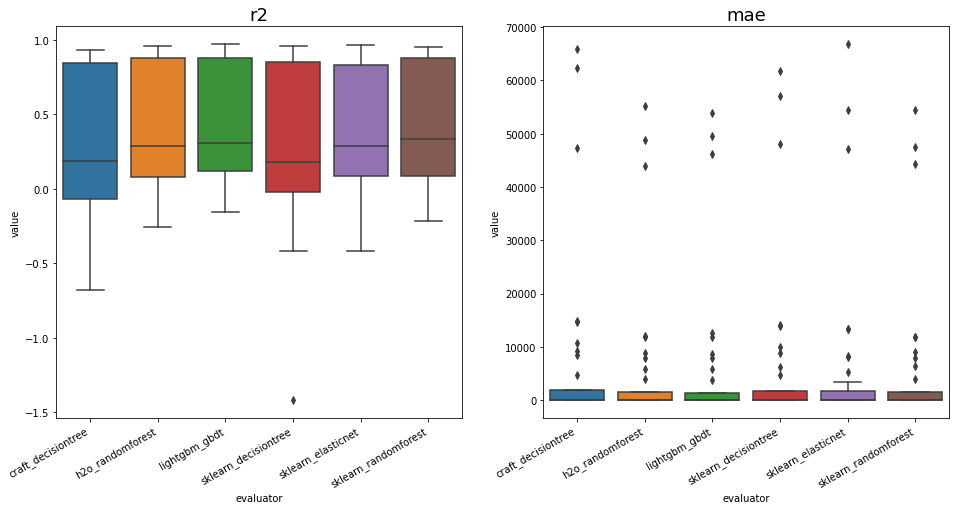

In [27]:
n_rows = 2
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for ax_idx, metric_name in enumerate(["r2", "mae"]):
    df = mean_result_long_df[
        (mean_result_long_df["metric"] == metric_name)
        & (mean_result_long_df["is_test"])
    ]
    sns.boxplot(
        data=df, 
        x="evaluator",
        y="value",
        ax=axes[ax_idx]
    )
    axes[ax_idx].set_title(metric_name, fontsize=18)
fig.autofmt_xdate()
plt.show()

### *Remarks*
- **This metrics should not be interpreted.**. They are here so that the following metrics are not misunderstood.
- Nonetheless we see some r2 are very poor. Maybe some datasets could profit from weather and holiday data.

## *per dataset*

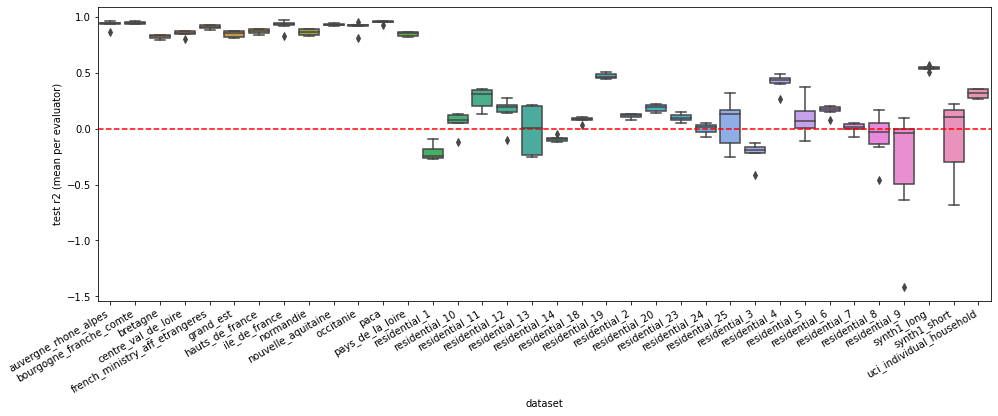

In [28]:
fig, ax = plt.subplots(figsize=(16, 6))
df = mean_result_long_df[(mean_result_long_df["metric"] == "r2") & (mean_result_long_df["is_test"])]
sns.boxplot(data=df, x="dataset", y="value", ax=ax)
ax.axhline(0, linestyle="--", color="r")
ax.set_ylabel("test r2 (mean per evaluator)")
fig.autofmt_xdate()
#plt.savefig("../docs/tmp.png")
plt.show()

In [65]:
df = df.groupby(["dataset", "metric"])["value"].mean().reset_index()

In [66]:
df = pd.merge(df, info_df)

<AxesSubplot:xlabel='freq (hour)', ylabel='value'>

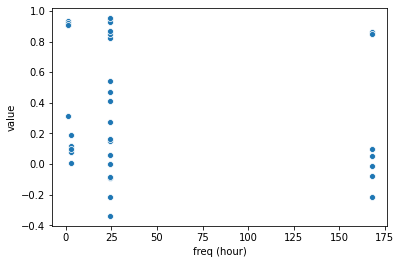

In [67]:
sns.scatterplot(data=df.groupby(["dataset", "freq (hour)"])["value"].mean().reset_index(), x="freq (hour)", y="value")

<AxesSubplot:xlabel='prediction_horizon (day)', ylabel='value'>

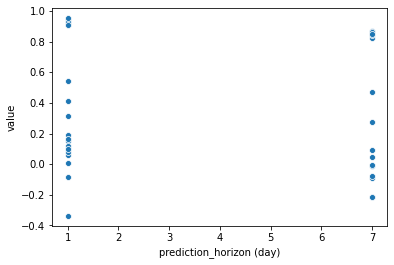

In [68]:
sns.scatterplot(data=df.groupby(["dataset", "prediction_horizon (day)"])["value"].mean().reset_index(), x="prediction_horizon (day)", y="value")

## per n_samples

In [48]:
df = pd.merge(mean_result_long_df, info_df[["dataset", "n_samples"]])
df.head()

,dataset,evaluator,metric,is_test,value,n_samples
0,auvergne_rhone_alpes,craft_decisiontree,mae,False,672.824951,52416
1,auvergne_rhone_alpes,craft_decisiontree,mae,True,611.352475,52416
2,auvergne_rhone_alpes,craft_decisiontree,mean_fit_time,NaN,1.675536,52416
3,auvergne_rhone_alpes,craft_decisiontree,r2,False,0.900689,52416
4,auvergne_rhone_alpes,craft_decisiontree,r2,True,0.933077,52416


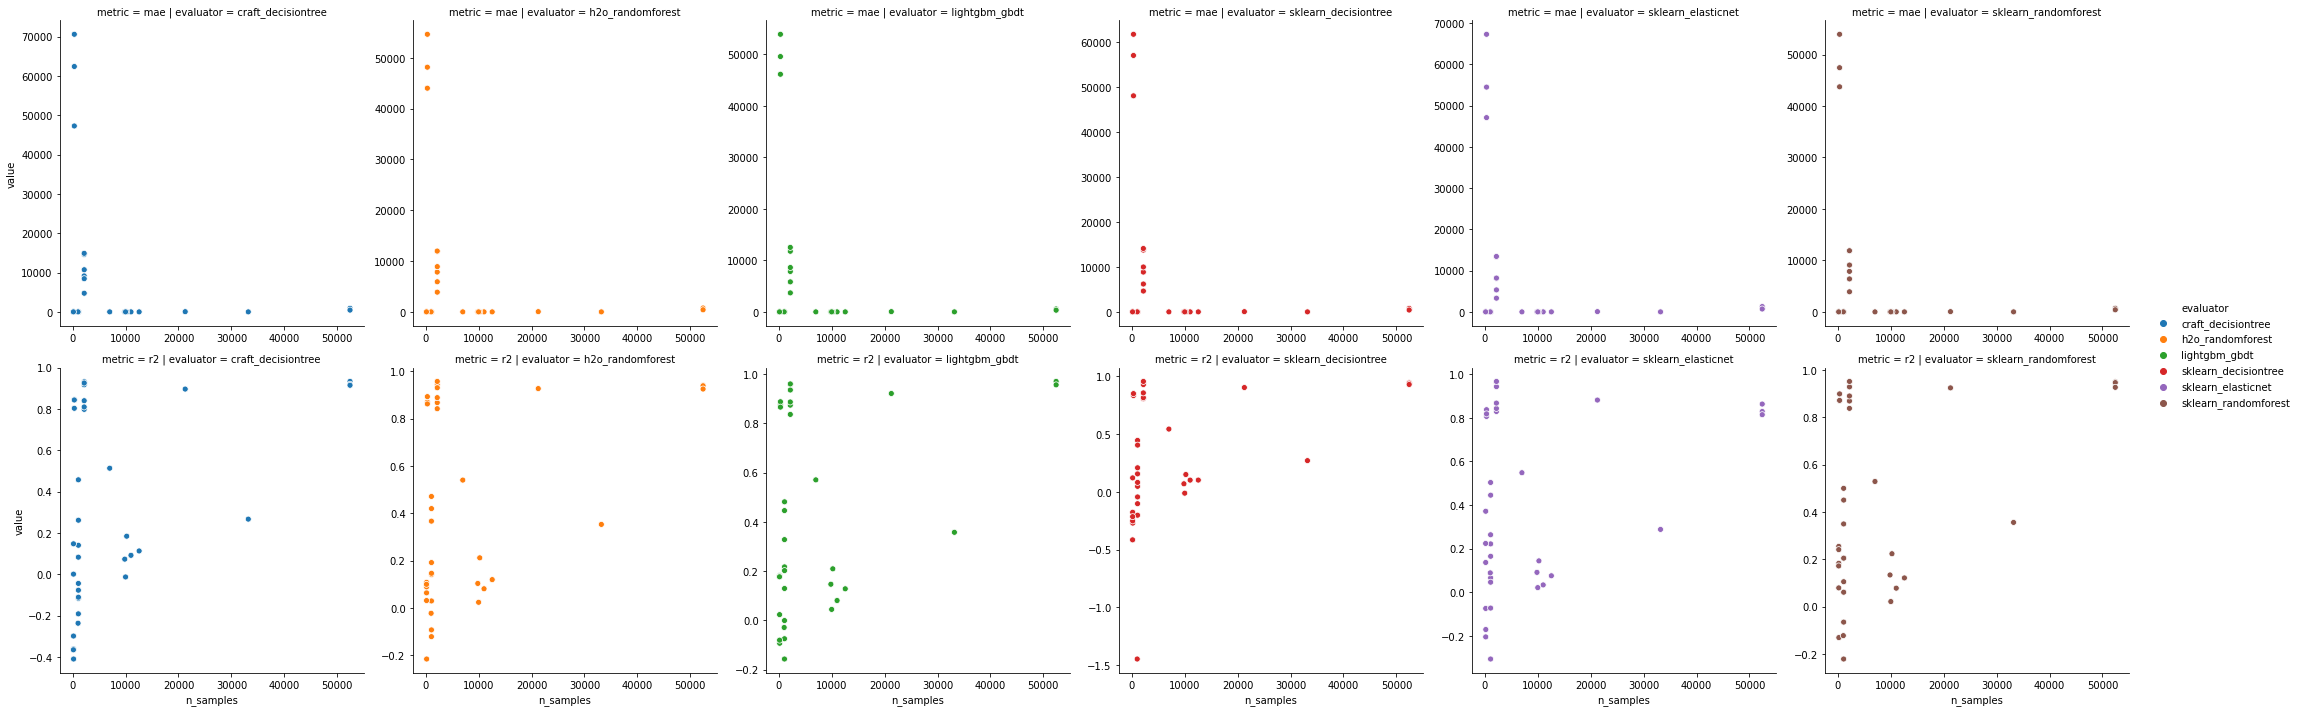

In [28]:
sns.relplot(data=df[df["is_test"] == True], x="n_samples", y="value", hue="evaluator", col="evaluator", row="metric", kind="scatter", facet_kws=dict(sharex=False, sharey=False))

# "Normalized" metrics

For each dataset, the best estimator has a score of 1 and the worst a score of 0.

In [69]:
metric_agg_df = result_long_df.groupby(["dataset", "metric", "is_test"])["value"].agg(["min", "max"]).reset_index()
normalized_df = pd.merge(result_long_df, metric_agg_df, on=["dataset", "metric", "is_test"])
normalized_df["value"] = (normalized_df["value"] - normalized_df["min"]) / (normalized_df["max"] - normalized_df["min"])

# fix here 
normalized_df.loc[:, "greater_is_better"] = False
normalized_df.loc[normalized_df["metric"] == "r2", "greater_is_better"] = True
mask = ~normalized_df["greater_is_better"]
normalized_df.loc[mask, "value"] = (normalized_df.loc[mask, "value"] * -1) + 1
normalized_df.drop(columns=["min", "max", "greater_is_better"], inplace=True)


normalized_df.head()

,evaluator,dataset,metric,is_test,fold_idx,value
0,sklearn_decisiontree,residential_12,r2,False,0.0,0.797679
1,sklearn_decisiontree,residential_12,r2,False,1.0,0.856155
2,sklearn_decisiontree,residential_12,r2,False,2.0,0.000000
3,sklearn_randomforest,residential_12,r2,False,0.0,1.000000
4,sklearn_randomforest,residential_12,r2,False,1.0,0.795413


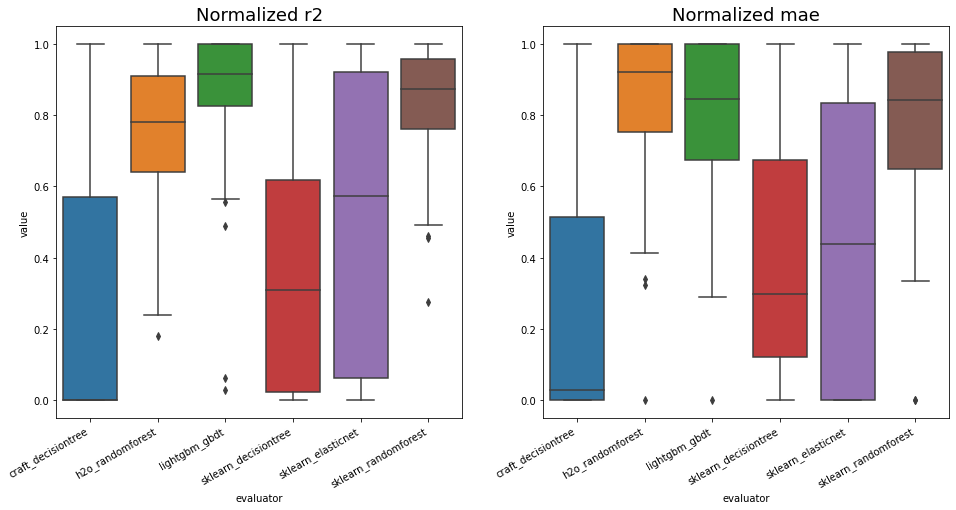

In [30]:
n_rows = 2
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for ax_idx, metric_name in enumerate(["r2", "mae"]):
    df = normalized_df[
        (normalized_df["metric"] == metric_name)
        & (normalized_df["is_test"])
    ]
    sns.boxplot(
        data=df, 
        x="evaluator",
        y="value",
        ax=axes[ax_idx]
    )
    axes[ax_idx].set_title(f"Normalized {metric_name}", fontsize=18)
fig.autofmt_xdate()
plt.show()

In [31]:
df = pd.merge(normalized_df, info_df[["dataset", "n_samples"]])
df.head()

,dataset,evaluator,metric,is_test,value,n_samples
0,auvergne_rhone_alpes,craft_decisiontree,mae,False,0.472167,52416
1,auvergne_rhone_alpes,h2o_randomforest,mae,False,0.682382,52416
2,auvergne_rhone_alpes,lightgbm_gbdt,mae,False,1.000000,52416
3,auvergne_rhone_alpes,sklearn_decisiontree,mae,False,0.606064,52416
4,auvergne_rhone_alpes,sklearn_elasticnet,mae,False,0.000000,52416


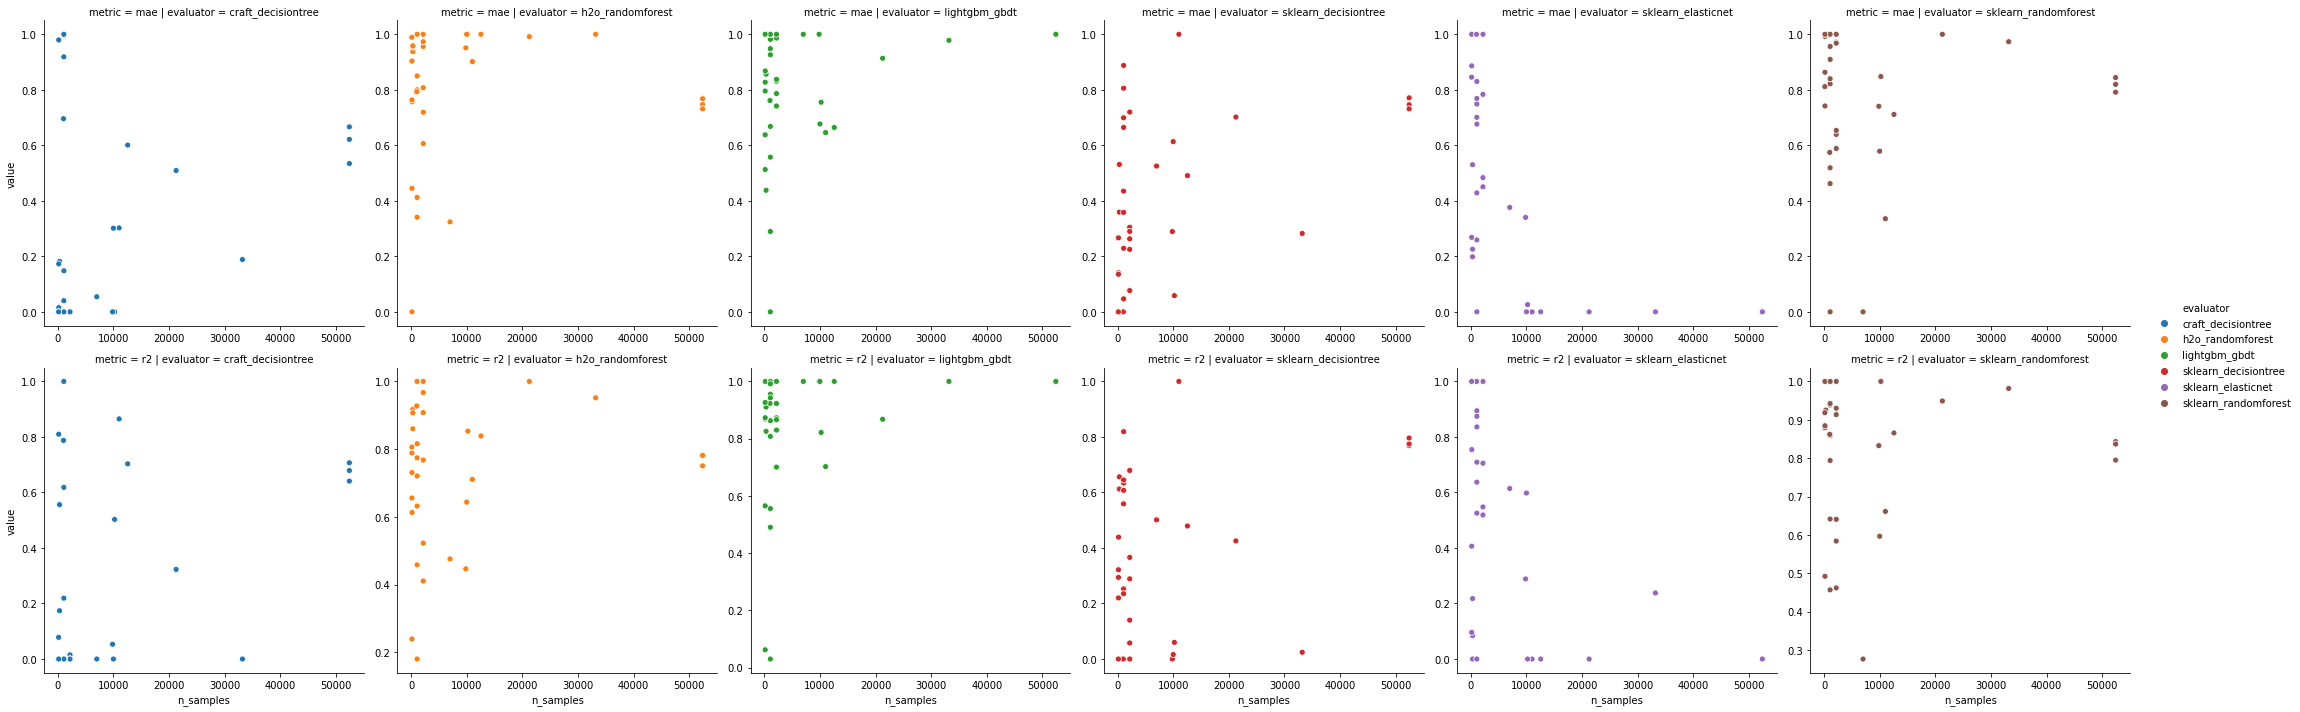

In [32]:
sns.relplot(data=df[df["is_test"] == True], x="n_samples", y="value", hue="evaluator", col="evaluator", row="metric", kind="scatter", facet_kws=dict(sharex=False, sharey=False))

<center><h1><b><span style="font-size: 96px;">ICI</span> NE PAS DEPASSER</b></h1></center>

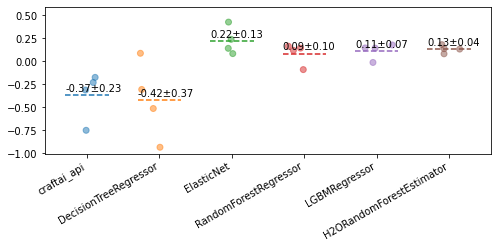

In [3]:
def scatterplot_one_dataset_one_metric(results, dataset_name, metric_name, ax):
    # initialization
    mask = (results["metric"] == metric_name) & (results["dataset"] == dataset_name) & (results["is_test"])
    results = results[mask].copy()
    
    x_labels = list(results["evaluator"].unique())
    x = results["evaluator"].apply(lambda el: x_labels.index(el))
    x_spread = x.astype(float).values + np.random.normal(loc=0.0, scale=0.1, size=len(x))
    y = results["value"]
    colors = "C" + x.astype(str)
    ax.scatter(x_spread, y, c=colors, alpha=0.5)
    # include 0
    y_min, y_max = ax.get_ybound()
    if y_max < 0:
        ax.set_ylim(y_min, 0)
    elif y_min > 0:
        ax.set_ylim(0, y_max)
    # add a bit to y_max
    y_min, y_max = ax.get_ybound()
    ax.set_ylim(y_min, max(y_max*1.1, y_max+0.1))
    
    for idx in range(len(x_labels)):
        mean = np.mean(y[x==idx])
        std = np.std(y[x==idx])
        ax.plot([idx-0.3, idx+0.3], [mean, mean], color=f"C{idx}", linestyle="--")
        y_min, y_max = ax.get_ybound()
        offset = (y_max - y_min) / 40
        ax.text(idx-0.3, mean+offset, f"{mean:.2f}±{std:.2f}")
    
    ax.xaxis.set_major_locator(plt.FixedLocator(np.arange(len(x_labels))))
    ax.set_xticklabels(x_labels)
    fig.autofmt_xdate()
    return ax

fig, ax = plt.subplots(figsize=(8,3))
ax = scatterplot_one_dataset_one_metric(results, "synth1_short", "r2", ax)
plt.show()

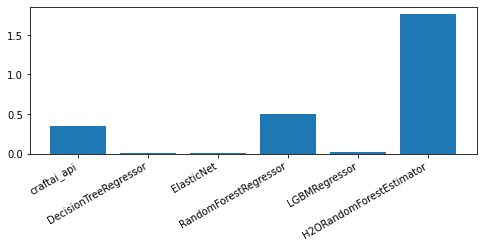

In [4]:
def barplot_one_dataset_times(results, dataset_name, time_name, ax):
    # initialization
    mask = (results["metric"] == time_name) & (results["dataset"] == dataset_name)
    results = results[mask].copy()
    
    
    x_labels = list(results["evaluator"].unique())
    x = list(range(len(x_labels)))
    height = [results.loc[results["evaluator"] == ev_name, "value"].iloc[0] for ev_name in x_labels]
    #import pdb; pdb.set_trace()
    ax.bar(x, height)
    
    ax.xaxis.set_major_locator(plt.FixedLocator(np.arange(len(x_labels))))
    ax.set_xticklabels(x_labels)
    fig.autofmt_xdate()
    return ax

fig, ax = plt.subplots(figsize=(8,3))
ax = barplot_one_dataset_times(results, "synth1_short", "mean_fit_time", ax)
plt.show()

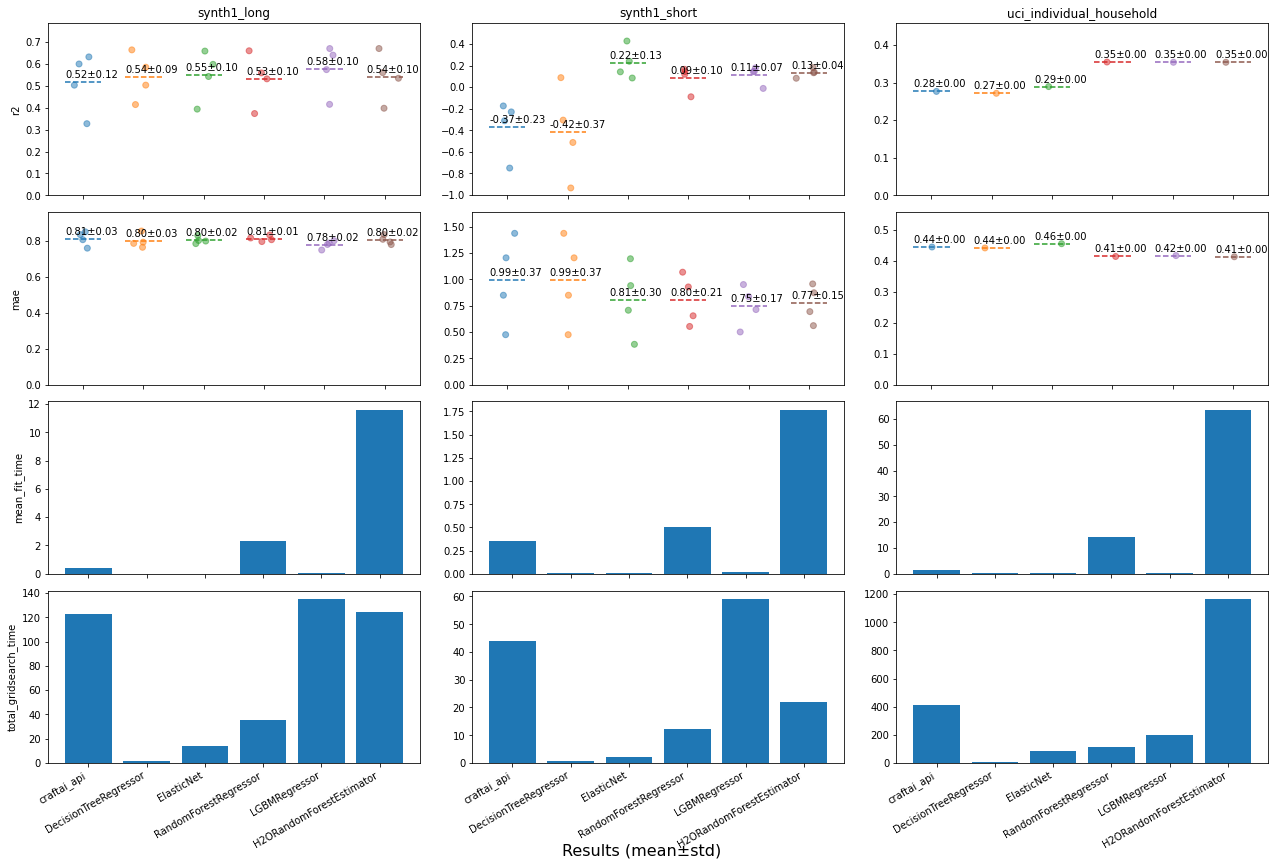

In [5]:
def scatterplot_all(results):
    ds_names = sorted(list(results["dataset"].unique()))
    m_names = list(results["metric"].unique())
    m_names = [el for el in m_names if not "time" in el] + [el for el in m_names if "time" in el]
    n_rows = len(m_names)
    n_cols = len(ds_names)
    fig, axes = plt.subplots(n_rows, n_cols, squeeze=False, figsize=(6*n_cols, 3*n_rows))
    for i, m_name in enumerate(m_names):
        for j, ds_name in enumerate(ds_names):
            ax = axes[i, j]
            if m_name in ["mean_fit_time", "gridsearch_time"]:
                ax = barplot_one_dataset_times(results, ds_name, m_name, ax)
            else:
                ax = scatterplot_one_dataset_one_metric(results, ds_name, m_name, ax)
    for i, m_name in enumerate(m_names):
        axes[i, 0].set_ylabel(m_name)
    for j, ds_name in enumerate(ds_names):
        axes[0, j].set_title(ds_name)
        fig.suptitle('Results (mean±std)', fontsize=16, y=0.02)
    fig.autofmt_xdate()
    return axes

ax = scatterplot_all(results)
plt.tight_layout()
plt.savefig("../docs/results.png")
plt.show()

In [6]:
pd.DataFrame([
    {"name": "iris", "n_samples": 150, "n_features": 4, "n_categorical_features": 0, "n_numerical_features": 4, "n_temporal_features": 0},
    {"name": "synth1_long", "n_samples": 7000, "n_features": 5, "n_categorical_features": 2, "n_numerical_features": 2, "n_temporal_features": 1},
    {"name": "synth1_short", "n_samples": 140, "n_features": 5, "n_categorical_features": 2, "n_numerical_features": 2, "n_temporal_features": 1},
    {"name": "uci_individual_household", "n_samples": 33190, "n_features": 13, "n_categorical_features": 0, "n_numerical_features": 8, "n_temporal_features": 5},
]
).set_index("name")

,n_samples,n_features,n_categorical_features,n_numerical_features,n_temporal_features
name,,,,,
iris,150,4,0,4,0
synth1_long,7000,5,2,2,1
synth1_short,140,5,2,2,1
uci_individual_household,33190,13,0,8,5
